In [36]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import matplotlib.pyplot as plt


data = pd.read_csv("healthcare-dataset-stroke-data.csv")

balanced_data = data.dropna()
balanced_data = balanced_data.drop(columns= "id")
balanced_data = balanced_data[balanced_data.age > 20]
balanced_data = balanced_data.drop(balanced_data.index[balanced_data["gender"] == "Other"])
balanced_data = balanced_data.drop(balanced_data.index[balanced_data["work_type"] == "Never_worked"])

features = ['gender', 'age', 'hypertension', 'heart_disease', 'ever_married', 'work_type', 'Residence_type', 'avg_glucose_level', "bmi", "smoking_status"]
cat_columns = ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status', 'hypertension', 'heart_disease']
num_columns = ['age', 'avg_glucose_level', 'bmi']

bal_data_train, bal_data_test = train_test_split(balanced_data, train_size = 0.8, random_state=1, stratify= balanced_data["stroke"])
bal_data_train, bal_data_val = train_test_split(bal_data_train, train_size = 0.8, random_state=1)

X_train = bal_data_train.drop('stroke', axis = 1)
y_train = bal_data_train['stroke']

X_val = bal_data_val.drop('stroke', axis = 1)
y_val = bal_data_val['stroke']

X_test = bal_data_test.drop('stroke', axis = 1)
y_test = bal_data_test['stroke']

In [37]:
preprocessing = ColumnTransformer([
    ('one-hot-encoder', OneHotEncoder(sparse_output=False), cat_columns),
    ('scaler', StandardScaler(), num_columns)
])

In [38]:
X_train2 = preprocessing.fit_transform(X_train)
X_val2 = preprocessing.transform(X_val)
X_test2 = preprocessing.transform(X_test)

Initial model starts at 0.07 recall

In [44]:
import tensorflow as tf

tf.random.set_seed(1)
model = tf.keras.Sequential()
model.add(tf.keras.layers.Input(shape=20))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dense(512, 'relu', kernel_regularizer= tf.keras.regularizers.l2(l=0.1)))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dense(256, 'relu', kernel_regularizer= tf.keras.regularizers.l2(l=0.1)))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dense(128, 'relu', kernel_regularizer= tf.keras.regularizers.l2(l=0.1)))
model.add(tf.keras.layers.Dense(1, "sigmoid"))
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=['Recall'])

model.summary()
#model.add(tf.keras.layers.Dense(128, 'relu', kernel_regularizer= tf.keras.regularizers.l2(l=0.1)))

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_21 (Bat  (None, 20)               80        
 chNormalization)                                                
                                                                 
 dense_44 (Dense)            (None, 512)               10752     
                                                                 
 batch_normalization_22 (Bat  (None, 512)              2048      
 chNormalization)                                                
                                                                 
 dense_45 (Dense)            (None, 256)               131328    
                                                                 
 batch_normalization_23 (Bat  (None, 256)              1024      
 chNormalization)                                                
                                                     

In [45]:
model_history = model.fit(X_train2, y_train, validation_data=(X_val2, y_val), epochs=50)

Epoch 1/50
79/79 [==============================] - 2s 10ms/step - loss: 21.8673 - recall: 0.0625 - val_loss: 4.6320 - val_recall: 0.0000e+00
Epoch 2/50
79/79 [==============================] - 1s 8ms/step - loss: 1.6389 - recall: 0.0000e+00 - val_loss: 0.6611 - val_recall: 0.0000e+00
Epoch 3/50
79/79 [==============================] - 1s 9ms/step - loss: 0.3318 - recall: 0.0000e+00 - val_loss: 0.3913 - val_recall: 0.0000e+00
Epoch 4/50
79/79 [==============================] - 1s 9ms/step - loss: 0.2445 - recall: 0.0000e+00 - val_loss: 0.3403 - val_recall: 0.0000e+00
Epoch 5/50
79/79 [==============================] - 1s 9ms/step - loss: 0.2474 - recall: 0.0000e+00 - val_loss: 0.2672 - val_recall: 0.0000e+00
Epoch 6/50
79/79 [==============================] - 1s 10ms/step - loss: 0.2385 - recall: 0.0000e+00 - val_loss: 0.2694 - val_recall: 0.0000e+00
Epoch 7/50
79/79 [==============================] - 1s 10ms/step - loss: 0.2340 - recall: 0.0000e+00 - val_loss: 0.2671 - val_recall: 0.0

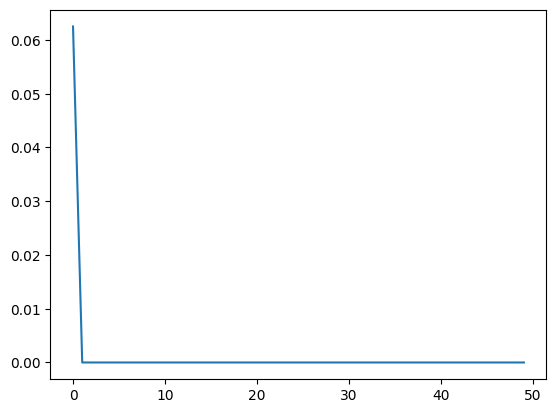

In [46]:
plt.plot(model_history.history['recall'])

In [ ]:
model.evaluate(X_test2, y_test)

25/25 [==============================] - 0s 5ms/step - loss: 0.1900 - recall: 0.0000e+00


[0.19000446796417236, 0.0]

https://imbalanced-learn.org/stable/miscellaneous.html

https://www.freecodecamp.org/news/binary-classification-made-simple-with-tensorflow/


In [ ]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]